<a href="https://colab.research.google.com/github/Ambg0231/DeepLearning/blob/main/%5BTALLER%5D_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller U3.05



**Ángela María Burgos, Sandra Beatriz Escobar**

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/acubillosunal/UBM-DEEP-LEARNING-1/main/init.py
import init; init.init(force_download=False);

replicating local resources


In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

setting tensorflow version in colab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.17.0'

In [ ]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle, bz2
from local.lib import mlutils
%matplotlib inline

### in this lab we will use the model trained in the notes to classify a different and smaller dataset

## Load the dataset

In [ ]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar_2.h5

--2024-09-07 01:36:11--  https://s3.amazonaws.com/rlx/mini_cifar_2.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.168.136, 52.217.123.184, 52.217.116.48, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.168.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9943835 (9.5M) [application/x-www-form-urlencoded]
Saving to: ‘mini_cifar_2.h5’

mini_cifar_2.h5     100%[===================>]   9.48M  5.81MB/s    in 1.6s    

2024-09-07 01:36:13 (5.81 MB/s) - ‘mini_cifar_2.h5’ saved [9943835/9943835]



(0.0, 1.0)

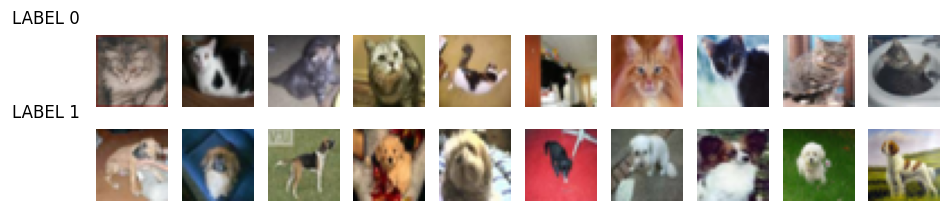

In [ ]:
import h5py
with h5py.File('mini_cifar_2.h5','r') as h5f:
    x_cifar = h5f["x"][:][:1000]
    y_cifar = h5f["y"][:][:1000]

x_cifar = x_cifar[y_cifar!=2]
y_cifar = y_cifar[y_cifar!=2]
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)
np.min(x_cifar), np.max(x_cifar)

## we use a small set of images for train

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(800, 32, 32, 3) (800,) (200, 32, 32, 3) (200,)

distribution of train classes
0    407
1    393
Name: count, dtype: int64

distribution of test classes
1    104
0     96
Name: count, dtype: int64


## Part 1: train a model from SCRATCH with this architecture from the above train and test classes

    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, 32, 32, 3)         0         
    _________________________________________________________________
    conv2d (Conv2D)              (None, 22, 22, 96)        34944     
    _________________________________________________________________
    max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
    _________________________________________________________________
    conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
    _________________________________________________________________
    flatten (Flatten)            (None, 60)                0         
    _________________________________________________________________
    dense (Dense)                (None, 64)                3904      
    _________________________________________________________________
    dense_1 (Dense)              (None, 64)                4160      
    _________________________________________________________________
    dropout (Dropout)            (None, 64)                0         
    _________________________________________________________________
    output_1 (Dense)             (None, 2)                 130       
    =================================================================
    Total params: 740,158
    Trainable params: 740,158
    Non-trainable params: 0
    _________________________________________________________________


observe that it is the same architecture as in the Transfer Leraning notes but:

- the output layer only has two neurons as we are doing now binary classification
- there are more and larger fully connected layers

**you should get**:
- very bad (almost random) performance on test
- very slow dropping of loss in train


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import time
def get_model(num_classes, img_size=32, compile=True):

    print ("using",num_classes,"classes")

    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])


    return model

def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time.time()))
    #model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}


In [ ]:
model1 = get_model(num_classes=2, img_size=32, compile=True)
model1.summary()

using 2 classes


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,778 (1.36 MB)

 Trainable params: 355,778 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train( .... )
# Parámetros de entrenamiento
batch_size = 32
epochs = 10
model_name = "cifar10_model"

# Entrenar el modelo
results = train(model1, batch_size=batch_size, epochs=epochs, model_name=model_name)
print(results)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.5096 - loss: 0.7002 - val_accuracy: 0.5500 - val_loss: 0.6889
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5365 - loss: 0.6893 - val_accuracy: 0.5050 - val_loss: 0.6846
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5592 - loss: 0.6866 - val_accuracy: 0.5650 - val_loss: 0.6868
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6048 - loss: 0.6686 - val_accuracy: 0.5650 - val_loss: 0.6564
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6464 - loss: 0.6343 - val_accuracy: 0.6300 - val_loss: 0.6452
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6653 - loss: 0.6120 - val_accuracy: 0.6350 - val_loss: 0.6513
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.6671 - loss: 0.5910 - val_accuracy: 0.6400 - val_loss: 0.6416
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7204 - loss: 0.5557 - val_accuracy: 0.6400 - 

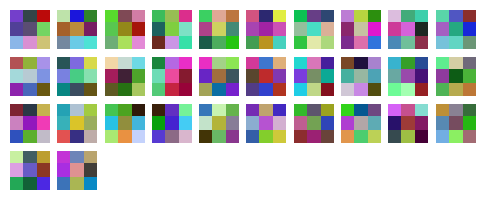

In [ ]:
mlutils.display_imgs(model1.get_weights()[0])

## Part 2: Transfer learning

- load the model saved in the Transfer Learning notes
- show the shapes of all weights from the model built in Part 1 above and the model just loaded
- create a new model with the same architecture of Part 1
- transfer the weights from the loaded model. **Transfer only weights with the same shapes**!!!
- train!!!

you should get:

- must faster drop in loss in train data, even to large overfitting
- some improvement of accuracy in test data
- the nice alexnet layer 1 filters after you train your model mostly unmodified

In [ ]:
model1.save("model1.h5")

In [ ]:
# Mostrar las formas de los pesos del modelo construido en la Parte 1
print("Pesos del modelo construido en la Parte 1:")
for layer in model1.layers:
    weights = layer.get_weights()
    if weights:
        print(f"{layer.name}: {[w.shape for w in weights]}")



Pesos del modelo construido en la Parte 1:
conv2d_12: [(3, 3, 3, 32), (32,)]
conv2d_13: [(3, 3, 32, 64), (64,)]
conv2d_14: [(3, 3, 64, 128), (128,)]
dense_8: [(2048, 128), (128,)]
dense_9: [(128, 2), (2,)]


In [ ]:
from tensorflow.keras.models import load_model

model1 = get_model (num_classes=2, img_size=32, compile=True )
model2 = load_model("model1.h5")
model2.summary()

using 2 classes


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,780 (1.36 MB)

 Trainable params: 355,778 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
w1 = ... # obtain weights of model 1
w2 = ... # obtain weights of model 2

In [ ]:
w1 = model1.get_weights()

# Obtain weights of model2
w2 = model2.get_weights()

In [ ]:
print (" -- model 1 weights --")
... # print all weights shapes of model 1

In [ ]:
print(" -- model 1 weights --")
for i, weight in enumerate(w1):
    print(f"Weight {i+1} shape: {weight.shape}")

 -- model 1 weights --
Weight 1 shape: (3, 3, 3, 32)
Weight 2 shape: (32,)
Weight 3 shape: (3, 3, 32, 64)
Weight 4 shape: (64,)
Weight 5 shape: (3, 3, 64, 128)
Weight 6 shape: (128,)
Weight 7 shape: (2048, 128)
Weight 8 shape: (128,)
Weight 9 shape: (128, 2)
Weight 10 shape: (2,)


In [ ]:
print(" -- model 2 weights --")
for i, weight in enumerate(w2):
    print(f"Weight {i+1} shape: {weight.shape}")

 -- model 2 weights --
Weight 1 shape: (3, 3, 3, 32)
Weight 2 shape: (32,)
Weight 3 shape: (3, 3, 32, 64)
Weight 4 shape: (64,)
Weight 5 shape: (3, 3, 64, 128)
Weight 6 shape: (128,)
Weight 7 shape: (2048, 128)
Weight 8 shape: (128,)
Weight 9 shape: (128, 2)
Weight 10 shape: (2,)


In [ ]:
print (" -- model 2 weights --")
... # print all weights shapes of model 2

### transfer weights!!

### you should transfer weights and biases of only the convolutional layers

`w1` must contain the transferred weights from `w2`

In [ ]:
import tensorflow as tf

def copy_conv_weights(model1, model2):
    for i, layer in enumerate(model1.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            weights = layer.get_weights()
            model2.layers[i].set_weights(weights)
            print(f"copying weights {i} --> {weights[0].shape}")
            print(f"copying weights {i+1} --> {weights[1].shape}")

    return model2

In [ ]:
copy_conv_weights(model1, model2)

copying weights 1 --> (3, 3, 3, 32)
copying weights 2 --> (32,)
copying weights 3 --> (3, 3, 32, 64)
copying weights 4 --> (64,)
copying weights 5 --> (3, 3, 64, 128)
copying weights 6 --> (128,)


<Functional name=functional_4, built=True>

In [ ]:
model1.set_weights(w1)

### train!!!

In [ ]:
train(... )

In [ ]:
# Compilar el modelo
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#Entrenar el modelo
Resultado = train(model1, batch_size=64, epochs=200, model_name="Nuevo_Modelo")
print(Resultado)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.8266 - loss: 0.3963 - val_accuracy: 0.6600 - val_loss: 0.6372
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.8805 - loss: 0.3105 - val_accuracy: 0.6950 - val_loss: 0.7005
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.8923 - loss: 0.2825 - val_accuracy: 0.6700 - val_loss: 0.7082
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9262 - loss: 0.2257 - val_accuracy: 0.6600 - val_loss: 0.6965
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9287 - loss: 0.1990 - val_accuracy: 0.6900 - val_loss: 0.7704
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9437 - loss: 0.1810 - val_accuracy: 0.6650 - val_loss: 0.8445
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9504 - loss: 0.1380 - val_accuracy: 0.6550 - val_loss: 0.8485
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9601 - loss: 0.1234 - val_accuracy:

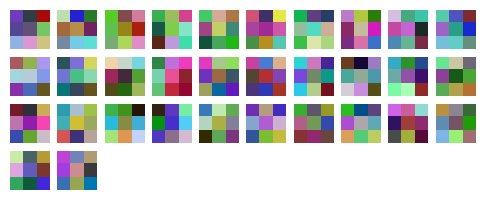

In [ ]:
mlutils.display_imgs(model1.get_weights()[0])